In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import scipy
import imageio
import PIL
from PIL import Image
import cv2
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json

import warnings

warnings.filterwarnings('ignore')

In [2]:
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}

In [3]:
def load_train_set(dirname,dict_characters):
    X_train = []
    Y_train = []
    for label,character in dict_characters.items():
        list_images = os.listdir(dirname+'/'+character)
        for image_name in list_images:
            image = imageio.imread(dirname+'/'+character+'/'+image_name)
            X_train.append(np.array(Image.fromarray(image).resize(size=(64, 64))))
            Y_train.append(label)
    return np.array(X_train), np.array(Y_train)

X_train, Y_train = load_train_set("simpson_dataset", dict_characters)

In [4]:
def load_test_set(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = imageio.imread(dirname+'/'+image_name)
        X_test.append(np.array(Image.fromarray(image).resize(size=(64, 64))))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)

X_test, Y_test = load_test_set("simpson_testset", dict_characters)

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
def display_samples(samples_index,imgs,obs, preds_classes=None,preds=None):
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_index[n]
            ax[row,col].imshow(imgs[index])
            
            actual_label = dict_characters[obs[index]].split("_")[0]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("fantasy")
            
            ax[row,col].text(1, 54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            
            if np.array(preds_classes).size > 1 and np.array(preds).size > 1:
                predicted_label = dict_characters[preds_classes[index]].split('_')[0]
                predicted_proba = max(preds[index])*100
                predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
                ax[row,col].text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')
            n += 1

In [7]:
def pick_up_random_element(elem_type,array):
    return int(random.choice(np.argwhere(array == elem_type)))

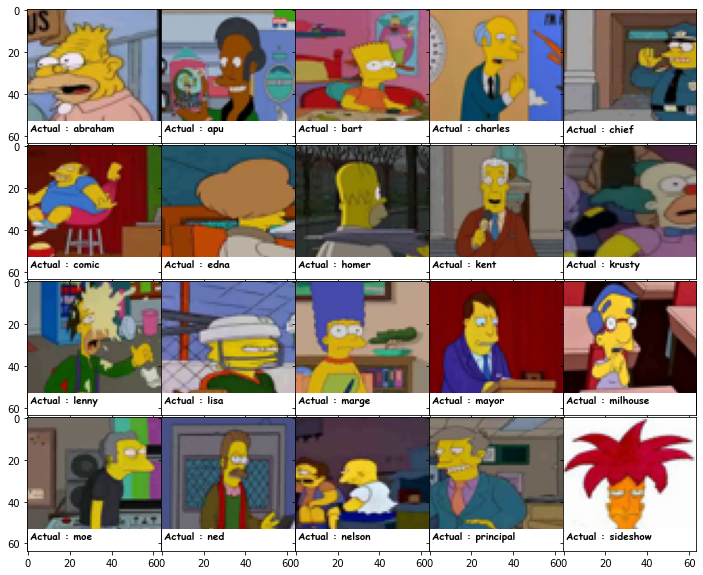

In [8]:
samples = [pick_up_random_element(elem_type,Y_train) for elem_type in range(20)]

display_samples(samples,X_train,Y_train)

In [9]:
Y_train = to_categorical(Y_train, num_classes = 20)
Y_test = to_categorical(Y_test, num_classes = 20)

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation = "softmax"))

In [11]:
optimizer = RMSprop(lr=0.001, decay=1e-6)

In [12]:
PRETRAINED = False

if PRETRAINED :
    json_file = open('best_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
   
    model = model_from_json(loaded_model_json)
    model.load_weights("best_model.hdf5")

In [13]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
save_best = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

Epoch 1/2
610/610 [==============================] - 337s 542ms/step - loss: 3.0163 - accuracy: 0.2220 - val_loss: 2.2753 - val_accuracy: 0.4051
Epoch 2/2
610/610 [==============================] - 305s 500ms/step - loss: 1.7982 - accuracy: 0.4793 - val_loss: 2.4640 - val_accuracy: 0.5343


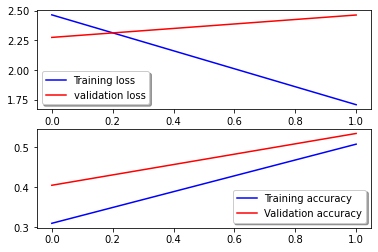

In [16]:
if PRETRAINED == False:
    
    epochs = 2  
    batch_size = 32
        
    datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)  
    
    
    datagen.fit(X_train)
    
    
    history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, shuffle=True),
                                  epochs = epochs, validation_data = (X_test,Y_test),
                                  steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction, save_best])
    
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    
    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    
    
    
    model_json = model.to_json()
    with open("best_model.json", "w") as json_file:
        json_file.write(model_json)
        
        model.save_weights("best_model.hdf5")

In [17]:
loss, acc = model.evaluate(X_test,Y_test,verbose = 0)

print("Simpson characters were predicted with a loss of {:.5f} and an accuracy of {:.2f}%".format(loss,acc*100))

Simpson characters were predicted with a loss of 2.46396 and an accuracy of 53.43%


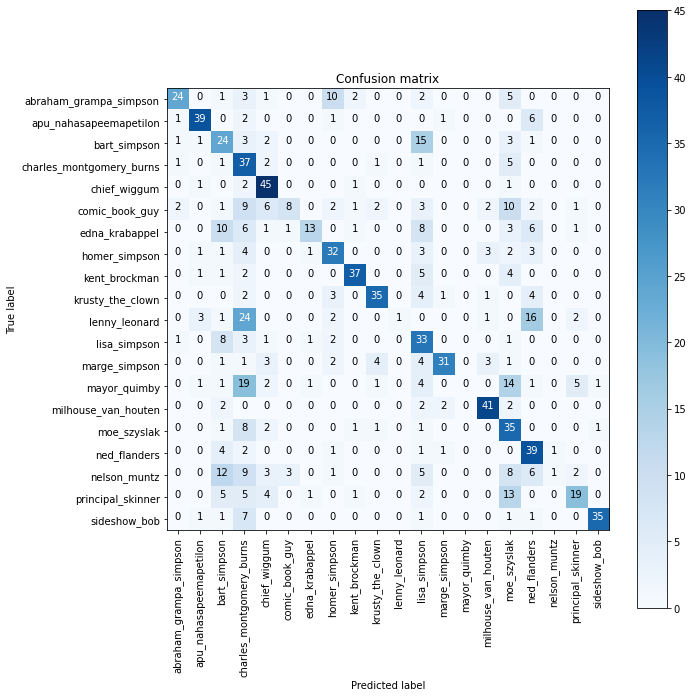

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 

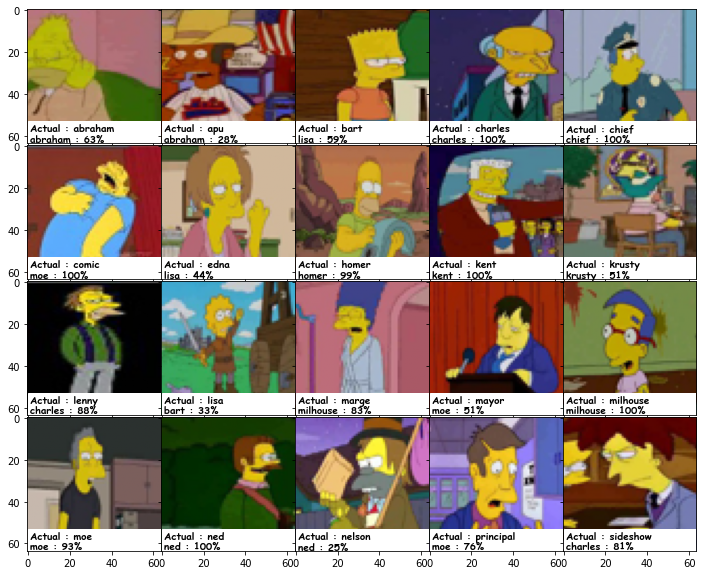

In [19]:
samples = [pick_up_random_element(elem_type,Y_true) for elem_type in range(20)]
display_samples(samples, X_test, Y_true, Y_pred_classes, Y_pred)